## Data preprocessing
in this file we gonna prepare, visualize and initialaze the label of each images and save that into a file

### Import data
get data from kaggle

In [ ]:
# !mkdir '/root/.kaggle'
# !echo <your username and key of kaggle account> > '/root/.kaggle/kaggle.json'
# !kaggle datasets download -d andrewmvd/face-mask-detection

In [ ]:
# !unzip '/content/face-mask-detection.zip'
# !rm -rf '/content/face-mask-detection.zip'

### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from plotly import graph_objects as go
from plotly import express as px
from xml.etree import ElementTree as et
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import Counter

### preprocess data

In [ ]:
# create an empty list
data = []
label2category = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
category2label = {0: 'with_mask', 1: 'without_mask', 2: 'mask_weared_incorrect'}

In [ ]:
for dir, _, files in os.walk('/content/annotations'):
  for file_ in files:
    dict_ = dict(img_path=None, objs=[])

    path = os.path.join(dir, file_)
    tree = et.parse(path)
    dict_['img_path'] = os.path.join('/content/images', tree.find('filename').text)
    for obj in tree.findall('object'):
      label = obj.find('name').text

      xmin = int(obj.find('bndbox/xmin').text)
      ymin = int(obj.find('bndbox/ymin').text)
      xmax = int(obj.find('bndbox/xmax').text)
      ymax = int(obj.find('bndbox/ymax').text)

      dict_['objs'].append([xmin, ymin, xmax, ymax, label2category[label]])
    data.append(dict_)

### Split data into input and output

In [ ]:
# cut only faces at the picture
%%time

x = []
y = []
IMG_SIZE = (64,64)

for _data in data:
  img_path = _data['img_path']
  for (xmin, ymin, xmax, ymax, label) in _data['objs']:
    img = cv2.imread(img_path)
    crop_img = img[ymin : ymax, xmin : xmax]
    crop_img = cv2.resize(crop_img, IMG_SIZE)
    crop_img = crop_img/255
    target = to_categorical(label, num_classes=3)
    x.append(crop_img); y.append(target)

CPU times: user 50 s, sys: 2.03 s, total: 52 s
Wall time: 52.5 s


### Visualize images

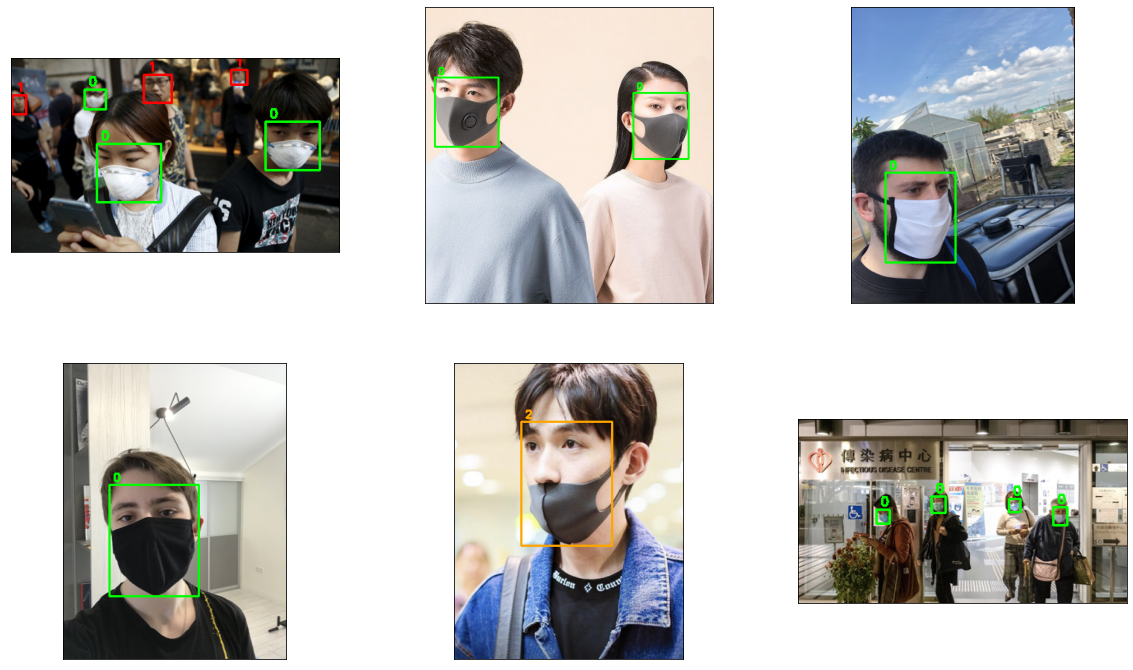

CPU times: user 692 ms, sys: 16.9 ms, total: 709 ms
Wall time: 715 ms


In [ ]:
# visualize images
%%time

plt.figure(figsize=(20,12))

for i, _data in enumerate(data[1:7]):
  img = cv2.imread(_data['img_path'])
  for (xmin, ymin, xmax, ymax, label) in _data['objs']:

    if label == 0:
      COLOR = (0,255,0)
    elif label == 1:
      COLOR = (0,0,255)
    else:
      COLOR = (0,165,255)

    cv2.rectangle(img , (xmin, ymin), (xmax, ymax), COLOR, 2)
    cv2.putText(img, str(label), (xmin+5, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLOR, 2)
  plt.subplot(2,3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

In [ ]:
labels = []
for _data in data:
  for (xmin, ymin, xmax, ymax, label) in _data['objs']:
    label = category2label[label]
    labels.append(label)

labels = np.array(labels)
labels_count = Counter(labels)

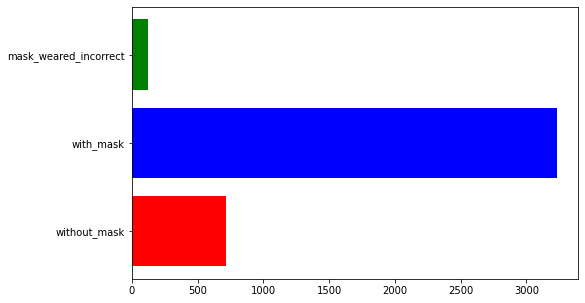

In [ ]:
plt.figure(figsize=(8,5))
# plt.barh(labels_count.keys(), labels_count.values(), color=['r', 'b', 'g'])
# plt.show()

plt.barh(list(labels_count.keys()), list(labels_count.values()), color=['r', 'b', 'g'])
plt.show()

### Split data into train and test data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [ ]:
def category_convert(data, counter=True):
  num = []
  for i in range(len(data)):
    num.append(category2label[data[i].argmax()])
  if counter:
    num = Counter(num)
  return num

def percent(dic):
  per = []
  values = dic.values()
  _sum = sum(values)
  
  for value in values:
    num = (value / _sum) * 100
    per.append(num)
  
  return per

In [ ]:
num_train = category_convert(y_train)
num_test = category_convert(y_test)

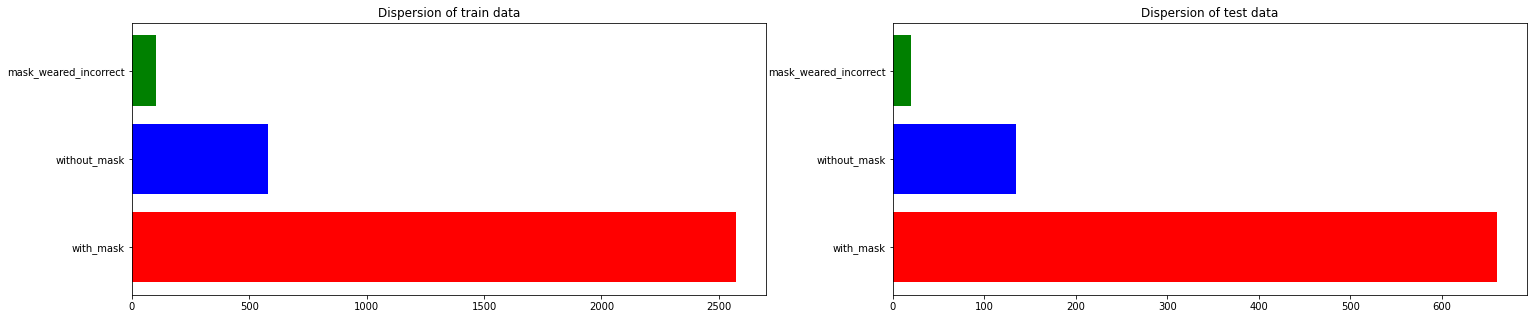

In [ ]:
plt.figure(figsize=(25,5))

plt.subplot(1,2,1)
plt.title('Dispersion of train data')
plt.barh(list(num_train.keys()), list(num_train.values()), color=['r', 'b', 'g'], )

plt.subplot(1,2,2)
plt.title('Dispersion of test data')
plt.barh(list(num_test.keys()), list(num_test.values()), color=['r', 'b', 'g'])

plt.show()

In [ ]:
wm, wom, mwi = percent(num_train)
wm1, wom1, mwi1 = percent(num_test)

print('with mask: {:.2f} %, without mask: {:.2f} %, mask weard incorrect: {:.2f} %'.format(wm, wom, mwi))
print('with mask: {:.2f} %, without mask: {:.2f} %, mask weard incorrect: {:.2f} %'.format(wm1, wom1, mwi1))

with mask: 78.97 %, without mask: 17.87 %, mask weard incorrect: 3.16 %
with mask: 80.98 %, without mask: 16.56 %, mask weard incorrect: 2.45 %


### save data into npz file

In [ ]:
np.savez('masks_data', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)